In [1]:
import pandas as pd

length before clustering = 6542
length after clustering = 4918
Total points:              4918
Noise points (-1 cluster): 0
Unique clusters:           1434
Rows with duplicates:      4918
Single-point clusters:    0
Max duplicate count:      11
Min duplicate count:      1
Mean duplicate count:     3.03
Std duplicate count:      1.72
Cluster 1155 → 12 points
      latitude  longitude
5113    217864     144365
5118    217864     144365
5119    217864     144365
5125    217864     144365
5134    217864     144365
5415    217864     144365
5417    217864     144365
5418    217864     144365
5436    217864     144365
5449    217864     144365
5461    217864     144365
5470    217864     144365


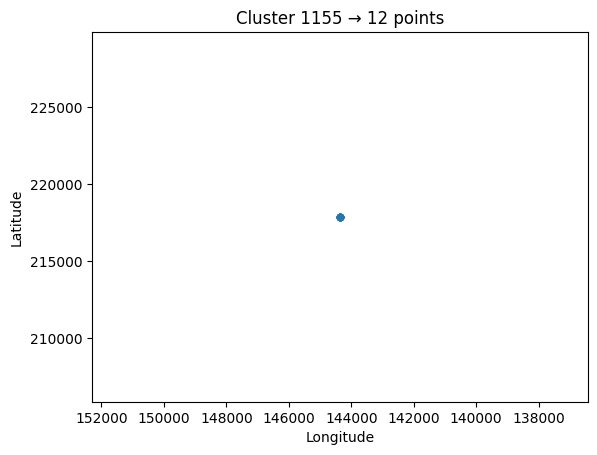

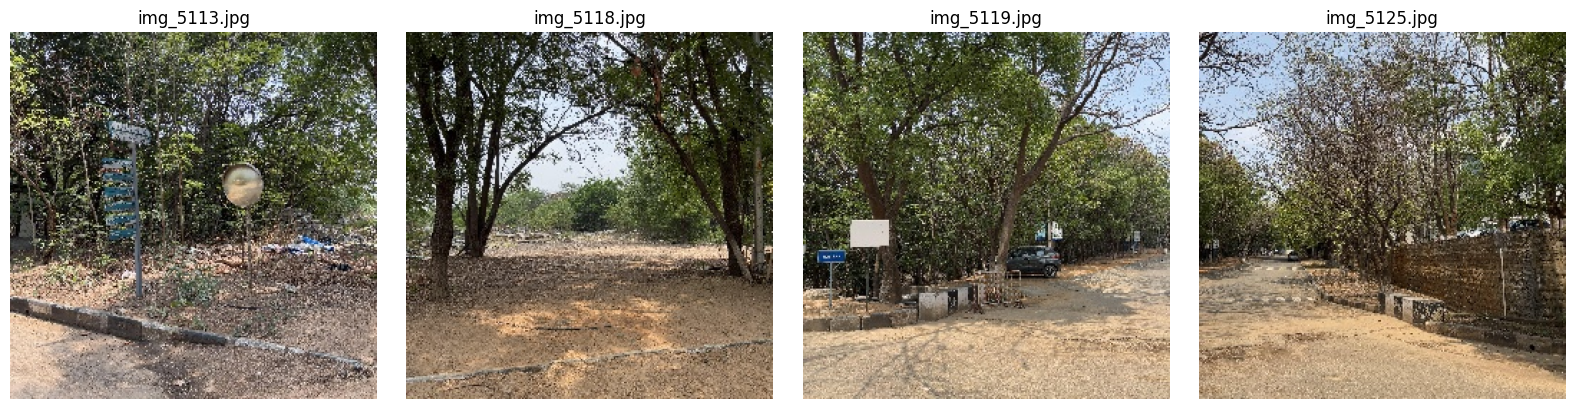

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def load_data(csv_path: Path) -> pd.DataFrame:
    """Load labels CSV into a DataFrame."""
    return pd.read_csv(csv_path)

def cluster_data(
    df: pd.DataFrame,
    eps_degrees: float = 0.0001,
    min_samples: int = 2,
    metric: str = 'euclidean'
) -> pd.DataFrame:
    """
    Cluster GPS points using Euclidean distance on [lat, lon] in degrees.

    Parameters:
    - df: DataFrame with 'latitude' and 'longitude' columns in degrees.
    - eps_degrees: maximum distance (in degrees) for points to be considered in the same cluster
      (~0.0001° ≈ 11 m at the equator).
    - min_samples: minimum number of points to form a cluster (DBSCAN's min_samples). Single points
      within eps_degrees of fewer points will be labeled as noise (-1).
    - metric: distance metric for DBSCAN (default 'euclidean').

    Returns:
    - df with added 'cluster_id' and 'duplicate_count' columns.
      Noise points have cluster_id = -1.
    """
    coords = df[['latitude', 'longitude']].values
    labels = DBSCAN(
        eps=eps_degrees,
        min_samples=min_samples,
        metric=metric,
        n_jobs=-1
    ).fit_predict(coords)

    df2 = df.copy()
    print(f"length before clustering = {len(df2)}")
    df2['cluster_id']      = labels
    df2 = df2[df2['cluster_id'] != -1]  # remove noise points
    print(f"length after clustering = {len(df2)}")
    df2['cluster_size']    = df2.groupby('cluster_id')['cluster_id'].transform('count')
    df2['duplicate_count'] = df2['cluster_size'] - 1
    return df2.drop(columns='cluster_size')

def print_stats(df: pd.DataFrame) -> None:
    """Print summary statistics of the clustering."""
    dup = df['duplicate_count']
    total = len(df)
    noise = (df['cluster_id'] == -1).sum()
    print(f"Total points:              {total}")
    print(f"Noise points (-1 cluster): {noise}")
    print(f"Unique clusters:           {df['cluster_id'].nunique() - (1 if -1 in df['cluster_id'].unique() else 0)}")
    print(f"Rows with duplicates:      {(dup > 0).sum()}")
    print(f"Single-point clusters:    {(dup == 0).sum() - noise}")
    print(f"Max duplicate count:      {dup.max()}")
    print(f"Min duplicate count:      {dup.min()}")
    print(f"Mean duplicate count:     {dup.mean():.2f}")
    print(f"Std duplicate count:      {dup.std():.2f}")

def get_largest_cluster(
    df: pd.DataFrame
) -> tuple[pd.DataFrame, int, int]:
    """Return DataFrame for the largest cluster (excluding noise), its ID, and its size."""
    sizes = df[df['cluster_id'] != -1]['cluster_id'].value_counts()
    cid   = sizes.idxmax()
    return df[df['cluster_id'] == cid], cid, sizes[cid]

def plot_cluster_points(cluster_df: pd.DataFrame, cid: int, size: int) -> None:
    """Scatter-plot lat/lon of one cluster."""
    plt.figure()
    plt.scatter(cluster_df['longitude'], cluster_df['latitude'], s=20)
    plt.title(f"Cluster {cid} → {size} points")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.gca().invert_xaxis()
    plt.show()

def print_cluster_points(cluster_df: pd.DataFrame, cid: int, size: int) -> None:
    """Print lat/lon of points in the cluster."""
    print(f"Cluster {cid} → {size} points")
    print(cluster_df[['latitude', 'longitude']])

def show_cluster_images(
    cluster_df: pd.DataFrame,
    image_dir: Path,
    max_images: int = 4
) -> None:
    """Display up to `max_images` from the cluster."""
    files = cluster_df['filename'].tolist()[:max_images]
    fig, axes = plt.subplots(1, len(files), figsize=(4 * len(files), 4))
    if len(files) == 1:
        axes = [axes]
    for ax, fname in zip(axes, files):
        img = Image.open(image_dir / fname)
        ax.imshow(img)
        ax.set_title(fname)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Configuration
labels_csv    = Path("labels_train.csv")
images_folder = Path("images_train/images_train")
eps_degrees   = 0.0001  # ~11 m threshold
min_samples   = 2       # require at least 2 points per cluster

# Pipeline
df_all       = load_data(labels_csv)
df_clustered = cluster_data(
    df_all,
    eps_degrees=eps_degrees,
    min_samples=min_samples
)
print_stats(df_clustered)

cluster_df, cluster_id, cluster_size = get_largest_cluster(df_clustered)
print_cluster_points(cluster_df, cluster_id, cluster_size)
plot_cluster_points(cluster_df, cluster_id, cluster_size)
show_cluster_images(cluster_df, images_folder)


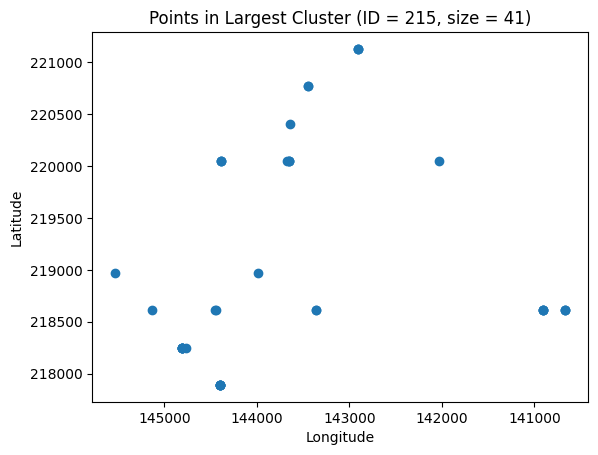

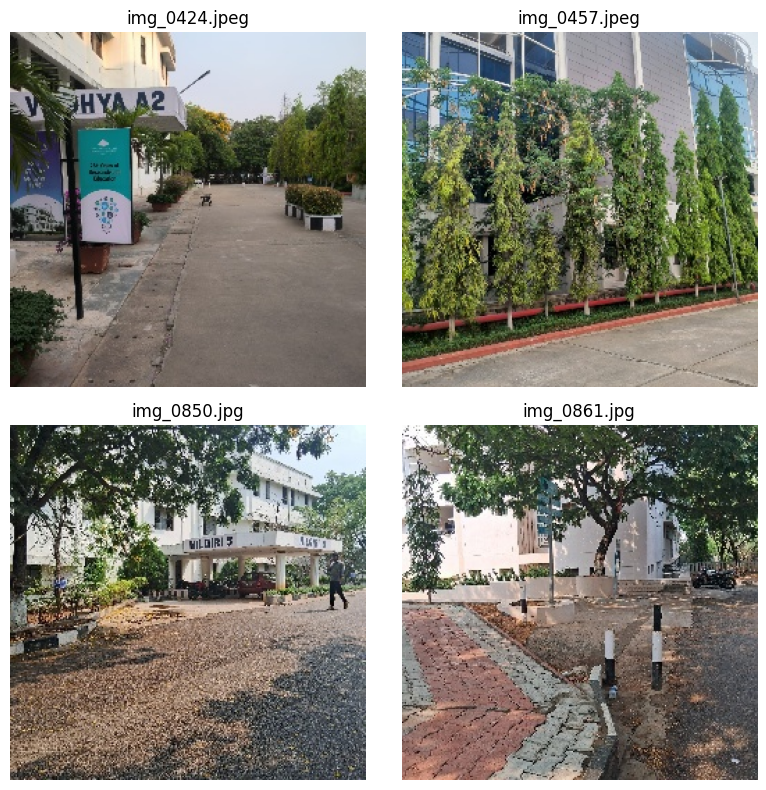